# Prediction of the function development using RNNs and its comparsion with other NNs

In this work I would like to use various neural network models to predict future price of BTC based on various cryptocurrency prices.  

### Importing libraries

I am going to use tensorflow and other libraries.

In [1]:
# disable gpu
#import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf


## Uncomment w
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [3]:
import glob
import joblib

In [4]:
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.grid'] = False

#### parameters

In [5]:
RATIO_TO_PREDICT = "BTCBUSD"
FUTURE_PERIOD_PREDICT = 1

#### Get all files from directory

In [6]:
mypath = "D:/crypto_data/all_18_may"

from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [7]:
symbols = []

for i in onlyfiles:
    
    head, sep ,nwm = i.partition('-')
    symbols.append(head)
    

In [8]:
symbols

['1INCHBUSD',
 'AAVEBUSD',
 'ACMBUSD',
 'ADABUSD',
 'AERGOBUSD',
 'ALGOBUSD',
 'ALICEBUSD',
 'ALPHABUSD',
 'ANTBUSD',
 'ARBUSD',
 'ATABUSD',
 'ATMBUSD',
 'ATOMBUSD',
 'AUCTIONBUSD',
 'AUDBUSD',
 'AUDIOBUSD',
 'AUTOBUSD',
 'AVABUSD',
 'AVAXBUSD',
 'AXSBUSD',
 'BADGERBUSD',
 'BAKEBUSD',
 'BALBUSD',
 'BANDBUSD',
 'BARBUSD',
 'BATBUSD',
 'BCHBUSD',
 'BELBUSD',
 'BIFIBUSD',
 'BNBBUSD',
 'BNTBUSD',
 'BTCBUSD',
 'BTCSTBUSD',
 'BTGBUSD',
 'BTTBUSD',
 'BURGERBUSD',
 'BZRXBUSD',
 'CAKEBUSD',
 'CELRBUSD',
 'CFXBUSD',
 'CHRBUSD',
 'CHZBUSD',
 'CKBBUSD',
 'COMPBUSD',
 'COTIBUSD',
 'COVERBUSD',
 'CREAMBUSD',
 'CRVBUSD',
 'CTKBUSD',
 'CTSIBUSD',
 'CVPBUSD',
 'DASHBUSD',
 'DATABUSD',
 'DEGOBUSD',
 'DEXEBUSD',
 'DFBUSD',
 'DGBBUSD',
 'DIABUSD',
 'DNTBUSD',
 'DOCKBUSD',
 'DODOBUSD',
 'DOGEBUSD',
 'DOTBUSD',
 'EGLDBUSD',
 'ENJBUSD',
 'EOSBUSD',
 'EPSBUSD',
 'ERNBUSD',
 'ETCBUSD',
 'ETHBUSD',
 'EURBUSD',
 'FILBUSD',
 'FIOBUSD',
 'FISBUSD',
 'FLMBUSD',
 'FORBUSD',
 'FORTHBUSD',
 'FRONTBUSD',
 'FTMBUSD',
 '

## Loading data

Load csv files obtained using binance API

In [9]:
main_df = pd.DataFrame()

#symbols = ['BTCBUSD','OCEANBUSD','ZRXBUSD','ATOMBUSD','BNTBUSD','ALGOBUSD','TWTBUSD','SUSHIBUSD']
symbols = ['BTCBUSD','BNTBUSD','DNTBUSD','ONTBUSD','ETHBUSD','NEOBUSD','XMRBUSD','BZRXBUSD','XVSBUSD','RSRBUSD','BTTBUSD','BATBUSD','DGBBUSD','ALGOBUSD','FORTHBUSD','CREAMBUSD','IDEXBUSD','TUSDBUSD','MDXBUSD','SHIBBUSD','USDCBUSD','GBPBUSD','EURBUSD','AUDBUSD','SLPBUSD']

for ratio in symbols:
    
    dataset = "D:/crypto_data/all_18_may/"+ratio+"-1m-data.csv"
    df = pd.read_csv(dataset, index_col="timestamp")
    
    df.rename(columns={"close": f"{ratio}_close"}, inplace=True)

    df = df[[f"{ratio}_close"]]
    
    df = df[(df.index < "2021-09-13 13:00:00")] 
    
    if len(main_df) == 0:
        main_df = df
    else:
        main_df = main_df.join(df, on='timestamp')


In [10]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 107070 entries, 2021-07-01 00:00:00 to 2021-09-13 12:59:00
Data columns (total 25 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   BTCBUSD_close    107070 non-null  float64
 1   BNTBUSD_close    107070 non-null  float64
 2   DNTBUSD_close    107070 non-null  float64
 3   ONTBUSD_close    107070 non-null  float64
 4   ETHBUSD_close    107070 non-null  float64
 5   NEOBUSD_close    107070 non-null  float64
 6   XMRBUSD_close    107070 non-null  float64
 7   BZRXBUSD_close   107070 non-null  float64
 8   XVSBUSD_close    107070 non-null  float64
 9   RSRBUSD_close    107070 non-null  float64
 10  BTTBUSD_close    107070 non-null  float64
 11  BATBUSD_close    107070 non-null  float64
 12  DGBBUSD_close    107070 non-null  float64
 13  ALGOBUSD_close   107070 non-null  float64
 14  FORTHBUSD_close  107070 non-null  float64
 15  CREAMBUSD_close  107070 non-null  float64
 16  IDEXBUSD_clo

In [11]:
main_df.shape

(107070, 25)

Because there are some NaN values we will get rid of them using code below.

In [12]:
main_df = main_df.dropna()

In [13]:
main_df_pct = main_df.pct_change().copy() 
main_df_pct =main_df_pct[1:]
#main_df[300:600].plot(subplots=True)
#main_df = main_df[1:]
#plt.show()

## Splitting data
It is common to split datasets into 3 parts. One is called training set and is uset for training our models. Another part is called validation set and after trainig we evaluate our model using this set and eventually change our model settings. After our model is done we will chceck results on thirs set which is calles test set. This last set is supposed to be uknown for our model so it should behave like "real world" data. We should pick model which does the best job with test set.

I will split main df into 3 parts with this ratio: (70%, 20%, 10%) train, validation, test.

In [14]:
def split_dataset(df):
    
    """
    Function returns train, validation and test dataframes. In ratio 70:20:10.

    Parameters
    ----------
    df: DataFrame
        DataFrame we would like to split

    Returns
    ----------
    Three dataframes.
    """
    
    n = len(df)
    train_df = df[0:int(n*0.6)]
    val_df = df[int(n*0.6):int(n*0.9)]
    test_df = df[int(n*0.9):]
    
    return train_df, val_df, test_df

In [15]:
#column_indices = {name: i for i, name in enumerate(df.columns)}
num_features = main_df.shape[1]

In [16]:
train_df_d, val_df_d, test_df_d = split_dataset(main_df_pct)

In [17]:
test_df_d

,BTCBUSD_close,BNTBUSD_close,DNTBUSD_close,ONTBUSD_close,ETHBUSD_close,NEOBUSD_close,XMRBUSD_close,BZRXBUSD_close,XVSBUSD_close,RSRBUSD_close,...,CREAMBUSD_close,IDEXBUSD_close,TUSDBUSD_close,MDXBUSD_close,SHIBBUSD_close,USDCBUSD_close,GBPBUSD_close,EURBUSD_close,AUDBUSD_close,SLPBUSD_close
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-09-06 02:33:00,0.000417,0.006326,0.000000,0.000000,-0.000102,0.000939,0.000000,0.001659,0.000514,0.000000,...,0.0,0.012237,0.0000,0.000000,0.000000,0.0000,0.000717,0.000000,-0.000404,-0.000850
2021-09-06 02:34:00,-0.000159,0.000000,0.000000,0.002101,0.000046,0.000313,-0.000322,0.000000,-0.000514,0.000000,...,0.0,-0.005487,0.0000,0.000000,0.000000,0.0001,0.000000,0.000000,0.000000,0.000850
2021-09-06 02:35:00,0.000618,0.000000,-0.002371,0.001942,0.000563,0.001251,0.001930,0.000000,-0.000771,0.000000,...,0.0,0.004311,0.0000,-0.000570,0.001339,-0.0001,0.000000,0.000846,0.000000,0.000000
2021-09-06 02:36:00,-0.000814,0.000000,0.002376,-0.000620,-0.000664,-0.000468,-0.000321,0.000000,-0.001287,-0.000787,...,0.0,-0.004206,0.0001,0.000000,-0.001337,0.0001,-0.000717,-0.000845,-0.000135,0.000000
2021-09-06 02:37:00,0.000299,0.000000,-0.002845,0.000000,0.000423,-0.000312,-0.000321,0.000000,0.001546,0.000394,...,0.0,0.012931,0.0000,0.006279,0.000000,0.0000,0.000000,0.000846,-0.000270,-0.000850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-13 12:55:00,0.000833,0.000000,0.000000,0.000000,0.000414,0.001055,0.001528,0.000000,0.001548,0.001734,...,0.0,0.000419,0.0000,0.004110,0.001538,0.0000,0.000000,0.000000,0.000000,0.004902
2021-09-13 12:56:00,-0.000433,0.000000,-0.005175,0.000000,-0.000296,-0.000421,0.000000,0.000000,0.000000,-0.001443,...,0.0,0.009052,0.0001,-0.001754,-0.001536,0.0000,0.000000,0.000000,0.000136,-0.002439
2021-09-13 12:57:00,0.000032,0.000000,0.003468,0.000000,0.000156,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,-0.003913,0.0000,0.005272,-0.001538,0.0000,0.000000,0.000000,0.000000,0.002445


## Normalizing data
Our model could work even without normalizing, but it improves training ability and performance. My data has different scales, for that reason I need to normalize it.

##### Z-score

In [18]:

from sklearn.preprocessing import StandardScaler
scaler_d = StandardScaler(with_mean=False)  # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

train_df_d = pd.DataFrame(scaler_d.fit_transform(train_df_d),columns = train_df_d.columns)
val_df_d = pd.DataFrame(scaler_d.transform(val_df_d),columns = val_df_d.columns)
test_df_d = pd.DataFrame(scaler_d.transform(test_df_d),columns = test_df_d.columns)

#joblib.dump(scaler_d, "scalers/scaler_big_pct_24_b_w_BTC.gz") 


""" 
scaler_my = StandardScaler(with_mean=False)

train_df_my = pd.DataFrame(scaler_my.fit_transform(train_df_my),columns = train_df_my.columns)
val_df_my = pd.DataFrame(scaler_my.transform(val_df_my),columns = val_df_my.columns)
test_df_my = pd.DataFrame(scaler_my.transform(test_df_my),columns = test_df_my.columns)

scaler_my = StandardScaler(with_mean=False)

train_df_my = pd.DataFrame(scaler_my.fit_transform(train_df_my),columns = train_df_my.columns)
val_df_my = pd.DataFrame(scaler_my.transform(val_df_my),columns = val_df_my.columns)
test_df_my = pd.DataFrame(scaler_my.transform(test_df_my),columns = test_df_my.columns)
"""

' \nscaler_my = StandardScaler()\n\ntrain_df_my = pd.DataFrame(scaler_my.fit_transform(train_df_my),columns = train_df_my.columns)\nval_df_my = pd.DataFrame(scaler_my.transform(val_df_my),columns = val_df_my.columns)\ntest_df_my = pd.DataFrame(scaler_my.transform(test_df_my),columns = test_df_my.columns)\n\nscaler_my = StandardScaler()\n\ntrain_df_my = pd.DataFrame(scaler_my.fit_transform(train_df_my),columns = train_df_my.columns)\nval_df_my = pd.DataFrame(scaler_my.transform(val_df_my),columns = val_df_my.columns)\ntest_df_my = pd.DataFrame(scaler_my.transform(test_df_my),columns = test_df_my.columns)\n'

### Data windowing

Models will make predictions using part of data called windows. 


In [19]:
class WindowGenerator():
    
    """
    Moving window class. Contains needed dataframes for training. 

    Parameters
    ----------
    input_width: int
        Dataframe we would like to split.
        
    input_width: int
        Width of window part model is supposed to predict.
        
    shift: int
        Shift between input and label.
        
    train_df: DataFrame
        Training dataframe
        
    val_df: DataFrame
        Validation dataframe
        
    test_df: DataFrame
        Test dataframe
    
    label_columns: 
        label column indices
    """
    
    
    def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None):
        
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        # This part takes arguemntes and calculate window size
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        

        # Window size is equal to input width and shift
        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width) # slice(0, i_w, None)
        
        # np.arange(5) -> array([0, 1, 2, 3, 4])
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

Code below splits data inside window class into inputs and labels.
Inputs are data from which our model is supposed to predict label, 
which is the actual correct value.

In [20]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :] 
    # (whole, input_slice, whole): (3, 12, 4) -> i_s=5 (3,5,4)
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [21]:
w2 = WindowGenerator(input_width=30, label_width=1, shift=1,train_df = train_df_d,val_df = val_df_d, test_df = test_df_d, label_columns=[RATIO_TO_PREDICT+'_close'])
w2


Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['BTCBUSD_close']

In [22]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df_d[:w2.total_window_size]),
                           np.array(train_df_d[100:100+w2.total_window_size]),
                           np.array(train_df_d[200:200+w2.total_window_size])])


In [23]:

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')


All shapes are: (batch, time, features)
Window shape: (3, 31, 25)
Inputs shape: (3, 30, 25)
labels shape: (3, 1, 1)


Simple vizualization of the split window with function plot().

In [24]:
w2.example = example_inputs, example_labels

In [25]:
def plot(self, model=None, plot_col=RATIO_TO_PREDICT+'_close', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(3, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs) # https://stackoverflow.com/questions/55308425/difference-between-modelx-and-model-predictx-in-tensorflow
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)
        if n == 0:
            plt.legend()
        
    plt.xlabel('Time [min]')

WindowGenerator.plot = plot

In [26]:
def plot_input_data(self,  model=None):
    inputs, labels = self.example
    
    print(inputs)
    plot(inputs)
    
WindowGenerator.plot_input_data = plot_input_data

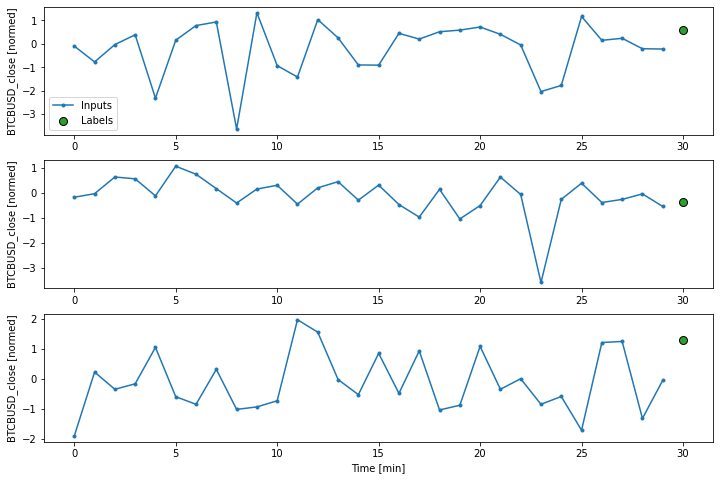

In [27]:
w2.plot()

#### Create dataset

Function below takes dataframe and converts it to tf.data.Dataset with (input_window, label_window) pairs.
First, we convert dataframe to np.array and then timeseries_dataset_from_array function converts it to dataset. 

In [28]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32) # convert data to np.array
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)
      # very useful function which converts data to dataset (input_window, label_window) from array

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset


In [29]:
@property  # https://www.python-course.eu/python3_properties.php
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

#### Define wide window

In [30]:
wide_window_d = WindowGenerator(
    input_width=30, label_width=30, shift=FUTURE_PERIOD_PREDICT,train_df = train_df_d,val_df = val_df_d, test_df = test_df_d,label_columns=[RATIO_TO_PREDICT+'_close'])

#### To compare prediction performances

In [31]:
val_performance = {}
performance = {}

## Models

MyModel class to make working with models easier. 

In [32]:
from tensorflow.keras.models import load_model

class MyModel():
    
    def __init__(self, model):
        self.model = model
        
    def load_model(self, dir_name):
        self.model = load_model(dir_name)
    
    def eval_mod(self, window, verbose):
        res = self.model.evaluate(window, verbose=verbose)
        print("Loss:", res[0], "MAE:", res[1])
        
    def save_model(self, name):
        self.model.save("models_pct\\models_21_09_2021_24_b_w_crypto_BTCBUSD_1\\"+ name +".model")
        
    def retrain_model(self, window, patience, epochs):
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min', restore_best_weights=True)
        history = self.model.fit(window.train, epochs=epochs, validation_data=window.val, callbacks=[early_stopping])
        self.history = history
        
    def compile_and_fit(self, window, patience=3, epochs=120):

        ## callbacks list https://www.tensorflow.org/api_docs/python/tf/keras/callbacks
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                        patience=patience,
                                                        mode="min", restore_best_weights=True)
        
        # https://github.com/Jaewan-Yun/optimizer-visualization
        # https://www.tensorflow.org/api_docs/python/tf/keras/Model
        opt = opt = tf.optimizers.Adam(0.01)
        
        self.model.compile(loss=tf.losses.MeanSquaredError(),
                    optimizer=opt,
                    metrics=[tf.metrics.MeanAbsoluteError()])

        history = self.model.fit(window.train, epochs=epochs,
                          validation_data=window.val,
                          callbacks=[early_stopping])
        return history

#### Training procedure
Because we will train more models let's create function which compiles and train desired model.

To plot learning process there is a function below.

In [33]:
def plot_loss(history, graph_param):
    plt.plot(history.history[str(graph_param)], label=str(graph_param))
    plt.plot(history.history['val_'+ str(graph_param)], label='val_' + str(graph_param))
    plt.xlabel('Epoch')
    plt.ylabel(graph_param)
    plt.legend()
    plt.grid(True)

### Recurrent neural network (LSTM)

[batch, timesteps, feature] 3D input

In [34]:
act = "tanh"
recurrent_act = "sigmoid"

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(1042, return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(1024, return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(1024, return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(1024, return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.Dense(32, activation=act),
    tf.keras.layers.Dense(units=1)
])

In [35]:
lstm = MyModel(lstm_model)

In [36]:
history = lstm.compile_and_fit(wide_window_d)

Epoch 1/120
2007/2007 [==============================] - 86s 39ms/step - loss: 1.0291 - mean_absolute_error: 0.6728 - val_loss: 0.6351 - val_mean_absolute_error: 0.5754
Epoch 2/120
2007/2007 [==============================] - 77s 39ms/step - loss: 1.0038 - mean_absolute_error: 0.6691 - val_loss: 0.6324 - val_mean_absolute_error: 0.5740
Epoch 3/120
2007/2007 [==============================] - 77s 39ms/step - loss: 1.0038 - mean_absolute_error: 0.6691 - val_loss: 0.6318 - val_mean_absolute_error: 0.5735
Epoch 4/120
2007/2007 [==============================] - 78s 39ms/step - loss: 1.0032 - mean_absolute_error: 0.6688 - val_loss: 0.6351 - val_mean_absolute_error: 0.5751
Epoch 5/120
2007/2007 [==============================] - 78s 39ms/step - loss: 1.0029 - mean_absolute_error: 0.6685 - val_loss: 0.6324 - val_mean_absolute_error: 0.5753
Epoch 6/120
2007/2007 [==============================] - 78s 39ms/step - loss: 1.0031 - mean_absolute_error: 0.6687 - val_loss: 0.6309 - val_mean_absolute_

In [37]:
val_performance['LSTM'] = lstm.eval_mod(wide_window_d.val, verbose=1)
performance['LSTM'] = lstm.eval_mod(wide_window_d.test, verbose=1)

1003/1003 [==============================] - 15s 15ms/step - loss: 0.6309 - mean_absolute_error: 0.5737
Loss: 0.6309130191802979 MAE: 0.5737236738204956
334/334 [==============================] - 5s 14ms/step - loss: 1.5360 - mean_absolute_error: 0.6996
Loss: 1.535995364189148 MAE: 0.6995801329612732


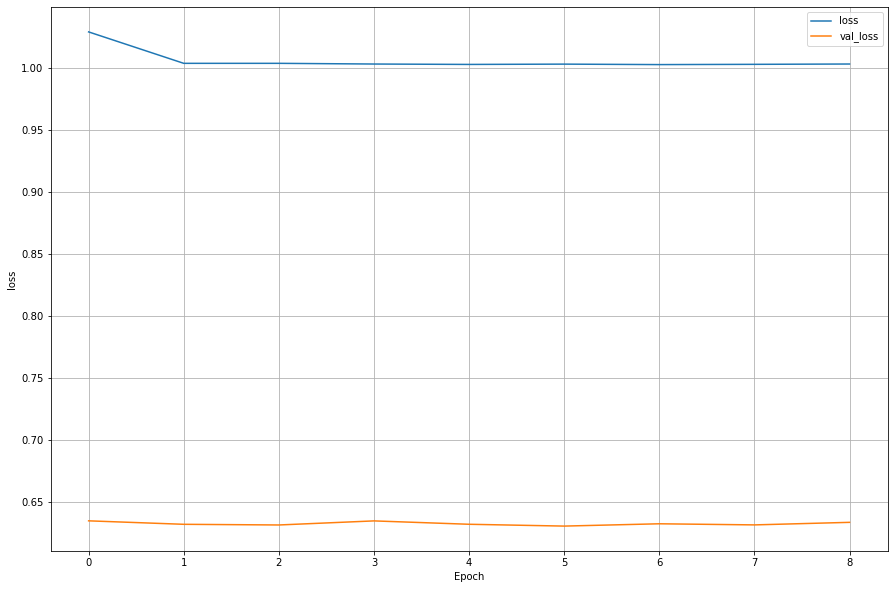

In [38]:
plot_loss(history, 'loss')

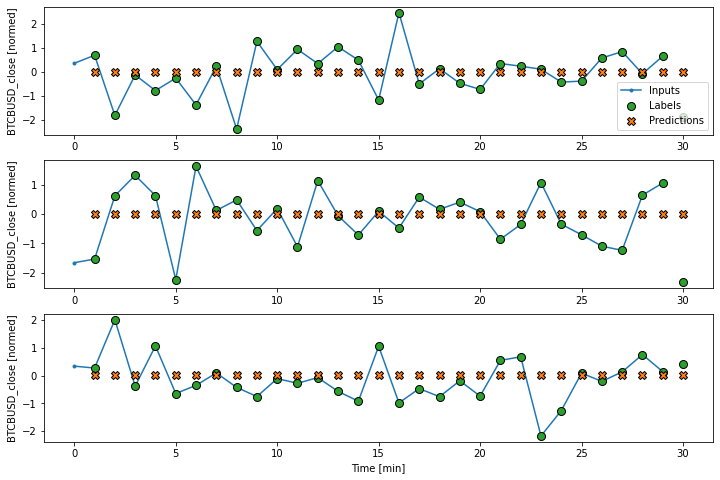

In [39]:
wide_window_d.plot(lstm.model)

In [40]:
lstm.save_model("lstm")

INFO:tensorflow:Assets written to: models_pct\models_21_09_2021_24_b_w_crypto_BTCBUSD_1\lstm.model\assets


INFO:tensorflow:Assets written to: models_pct\models_21_09_2021_24_b_w_crypto_BTCBUSD_1\lstm.model\assets


#### Loading model

In [41]:
lstm.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 1042)          4451424   
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 1042)          4168      
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 1024)          8466432   
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 1024)          4096      
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 1024)          8392704   
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 1024)          4096      
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 1024)          8

### Recurrent neural network (LSTM - bidirectional)

Parameters from https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional

In [42]:
lstm_model_bidirectional = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1024, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1024, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1024, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1024, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Dense(64, activation=act),
    tf.keras.layers.Dense(32, activation=act),
    tf.keras.layers.Dense(units=1)
])

In [43]:
lstm_bidi = MyModel(lstm_model_bidirectional)

In [44]:
history = lstm_bidi.compile_and_fit(wide_window_d)

Epoch 1/120
2007/2007 [==============================] - 171s 79ms/step - loss: 0.5399 - mean_absolute_error: 0.4412 - val_loss: 0.8620 - val_mean_absolute_error: 0.7337
Epoch 2/120
2007/2007 [==============================] - 156s 78ms/step - loss: 0.8592 - mean_absolute_error: 0.6256 - val_loss: 0.6327 - val_mean_absolute_error: 0.5737
Epoch 3/120
2007/2007 [==============================] - 156s 78ms/step - loss: 0.9999 - mean_absolute_error: 0.6676 - val_loss: 0.6350 - val_mean_absolute_error: 0.5776
Epoch 4/120
2007/2007 [==============================] - 157s 78ms/step - loss: 1.0028 - mean_absolute_error: 0.6687 - val_loss: 0.6305 - val_mean_absolute_error: 0.5730
Epoch 5/120
2007/2007 [==============================] - 157s 78ms/step - loss: 1.0032 - mean_absolute_error: 0.6687 - val_loss: 0.6314 - val_mean_absolute_error: 0.5743
Epoch 6/120
2007/2007 [==============================] - 156s 78ms/step - loss: 1.0030 - mean_absolute_error: 0.6688 - val_loss: 0.6327 - val_mean_abs

In [45]:
val_performance['LSTM-bidi'] = lstm_bidi.eval_mod(wide_window_d.val, verbose=1)
performance['LSTM-bidi'] = lstm_bidi.eval_mod(wide_window_d.test, verbose=1)

1003/1003 [==============================] - 28s 28ms/step - loss: 0.6305 - mean_absolute_error: 0.5730
Loss: 0.6305436491966248 MAE: 0.5729761719703674
334/334 [==============================] - 9s 28ms/step - loss: 1.5349 - mean_absolute_error: 0.6990: 1s - loss: 1
Loss: 1.5348930358886719 MAE: 0.6989869475364685


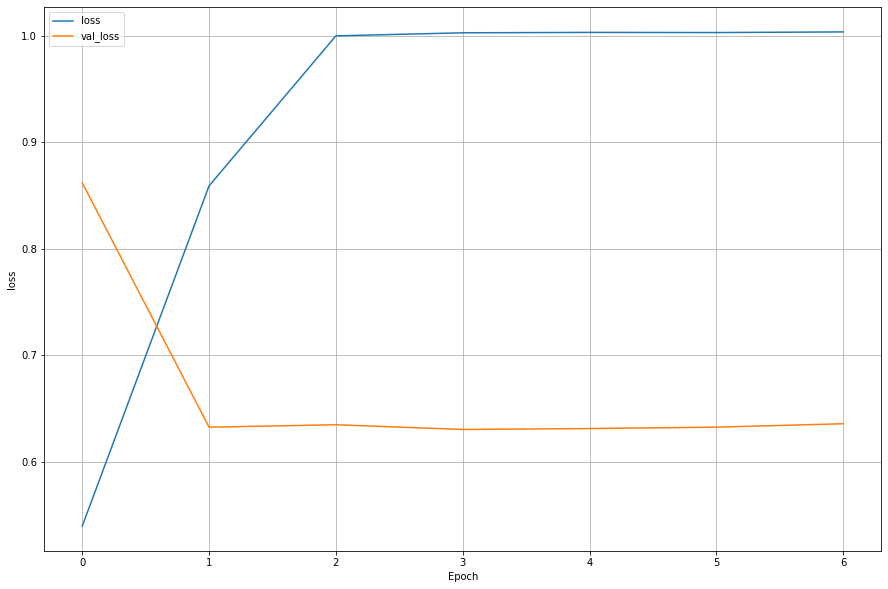

In [46]:
plot_loss(history, 'loss')

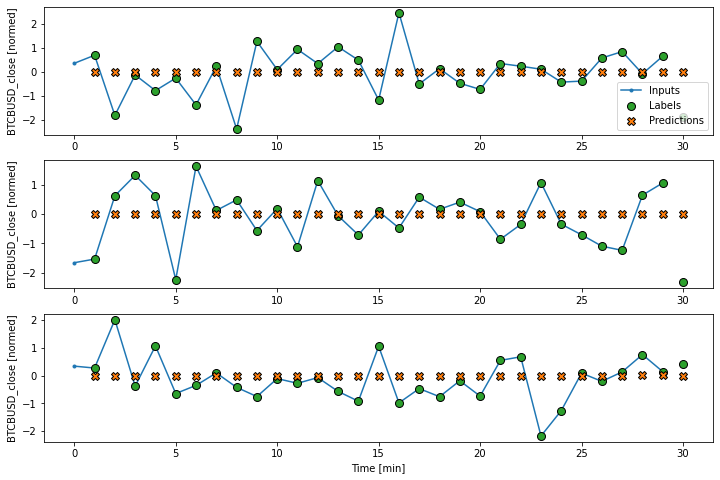

In [47]:
wide_window_d.plot(lstm_bidi.model)

In [48]:
lstm_bidi.save_model("l_bidi")

INFO:tensorflow:Assets written to: models_pct\models_21_09_2021_24_b_w_crypto_BTCBUSD_1\l_bidi.model\assets


INFO:tensorflow:Assets written to: models_pct\models_21_09_2021_24_b_w_crypto_BTCBUSD_1\l_bidi.model\assets


### Recurrent neural network (GRU)

Parameters from: https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU

In [49]:
gru_model = tf.keras.models.Sequential([
  
    tf.keras.layers.GRU(1024,  return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GRU(1024,  return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GRU(1024,  return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GRU(1024,  return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.Dense(64, activation=act),
    tf.keras.layers.Dense(32, activation=act),
    tf.keras.layers.Dense(units=1)
])


In [50]:
gru = MyModel(gru_model)

In [51]:
history = gru.compile_and_fit(wide_window_d)

Epoch 1/120
2007/2007 [==============================] - 69s 32ms/step - loss: 1.0090 - mean_absolute_error: 0.6709 - val_loss: 0.6323 - val_mean_absolute_error: 0.5738
Epoch 2/120
2007/2007 [==============================] - 64s 32ms/step - loss: 1.0017 - mean_absolute_error: 0.6679 - val_loss: 0.6311 - val_mean_absolute_error: 0.5739
Epoch 3/120
2007/2007 [==============================] - 63s 32ms/step - loss: 1.0017 - mean_absolute_error: 0.6679 - val_loss: 0.6333 - val_mean_absolute_error: 0.5761
Epoch 4/120
2007/2007 [==============================] - 63s 32ms/step - loss: 1.0023 - mean_absolute_error: 0.6683 - val_loss: 0.6307 - val_mean_absolute_error: 0.5734
Epoch 5/120
2007/2007 [==============================] - 65s 32ms/step - loss: 1.0033 - mean_absolute_error: 0.6689 - val_loss: 0.6376 - val_mean_absolute_error: 0.5764
Epoch 6/120
2007/2007 [==============================] - 63s 31ms/step - loss: 1.0032 - mean_absolute_error: 0.6688 - val_loss: 0.6306 - val_mean_absolute_

In [52]:
val_performance['GRU'] = gru.eval_mod(wide_window_d.val, verbose=1)
performance['GRU'] = gru.eval_mod(wide_window_d.test, verbose=1)

1003/1003 [==============================] - 10s 10ms/step - loss: 0.6306 - mean_absolute_error: 0.5731
Loss: 0.6305810213088989 MAE: 0.5731097459793091
334/334 [==============================] - 3s 10ms/step - loss: 1.5352 - mean_absolute_error: 0.6991
Loss: 1.5351836681365967 MAE: 0.6991024613380432


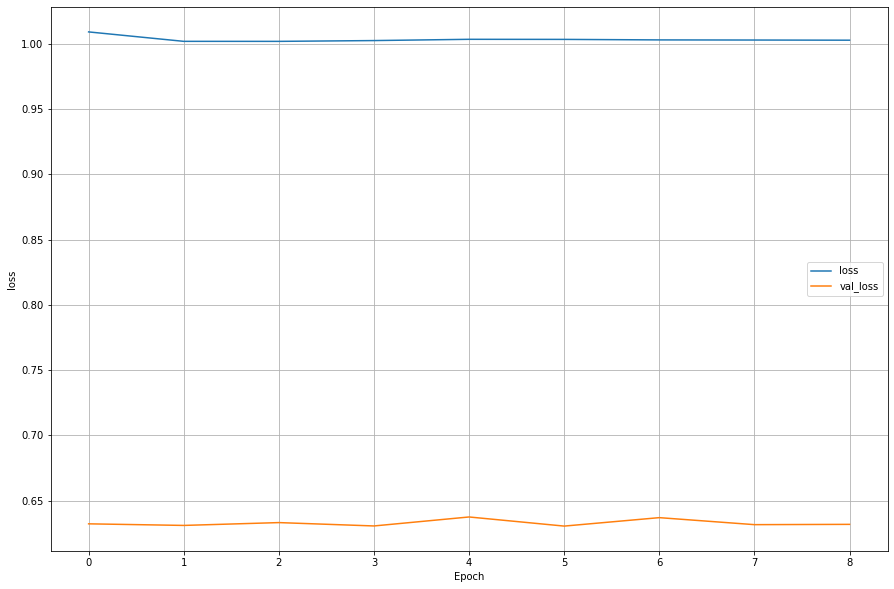

In [53]:
plot_loss(history, 'loss')

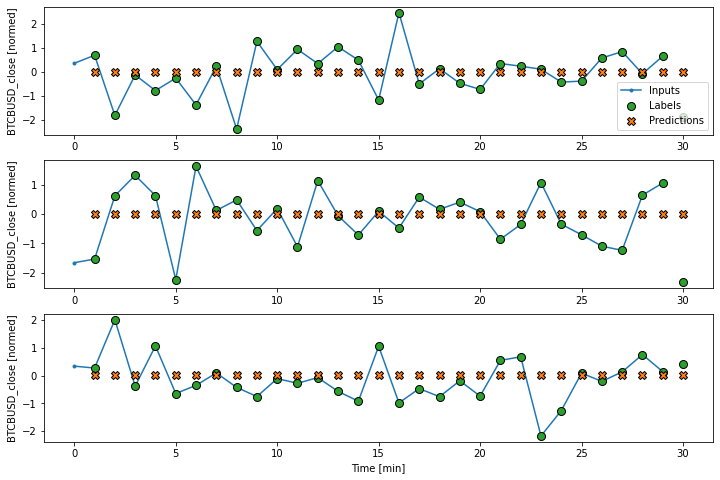

In [54]:
wide_window_d.plot(gru.model)

In [55]:
gru.save_model("gru")

INFO:tensorflow:Assets written to: models_pct\models_21_09_2021_24_b_w_crypto_BTCBUSD_1\gru.model\assets


INFO:tensorflow:Assets written to: models_pct\models_21_09_2021_24_b_w_crypto_BTCBUSD_1\gru.model\assets


### Recurrent neural network (GRU - bidirectional)

In [56]:
gru_model_bidirectional = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(1024, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(1024, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(1024, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(1024, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    # Shape => [batch, time, features
    tf.keras.layers.Dense(64, activation=act),
    tf.keras.layers.Dense(32, activation=act),
    tf.keras.layers.Dense(units=1)
])

In [57]:
gru_bidi = MyModel(gru_model_bidirectional)

In [58]:
history = gru_bidi.compile_and_fit(wide_window_d)

Epoch 1/120
2007/2007 [==============================] - 142s 65ms/step - loss: 0.4869 - mean_absolute_error: 0.4034 - val_loss: 2.0179 - val_mean_absolute_error: 1.1068
Epoch 2/120
2007/2007 [==============================] - 130s 65ms/step - loss: 1.0015 - mean_absolute_error: 0.6678 - val_loss: 0.6307 - val_mean_absolute_error: 0.5732
Epoch 3/120
2007/2007 [==============================] - 130s 65ms/step - loss: 1.0023 - mean_absolute_error: 0.6683 - val_loss: 0.6331 - val_mean_absolute_error: 0.5751
Epoch 4/120
2007/2007 [==============================] - 130s 65ms/step - loss: 1.0030 - mean_absolute_error: 0.6687 - val_loss: 0.6315 - val_mean_absolute_error: 0.5744
Epoch 5/120
2007/2007 [==============================] - 130s 65ms/step - loss: 1.0030 - mean_absolute_error: 0.6687 - val_loss: 0.6358 - val_mean_absolute_error: 0.5782


In [59]:
val_performance['GRU-bidi'] = gru_bidi.eval_mod(wide_window_d.val, verbose=1)
performance['GRU-bidi'] = gru_bidi.eval_mod(wide_window_d.test, verbose=1)

1003/1003 [==============================] - 21s 21ms/step - loss: 0.6307 - mean_absolute_error: 0.5732
Loss: 0.6306571960449219 MAE: 0.5731789469718933
334/334 [==============================] - 7s 22ms/step - loss: 1.5383 - mean_absolute_error: 0.6993
Loss: 1.5383027791976929 MAE: 0.699295699596405


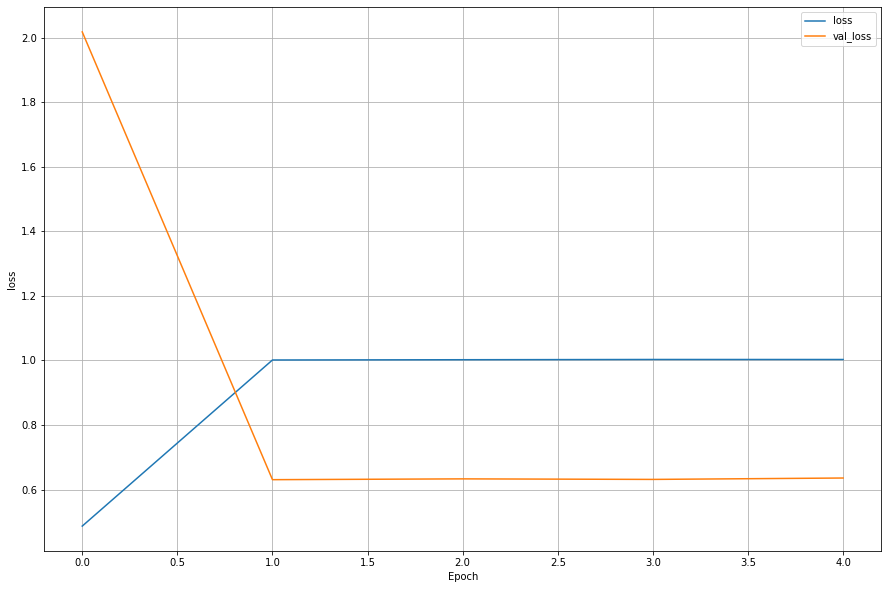

In [60]:
plot_loss(history, 'loss')

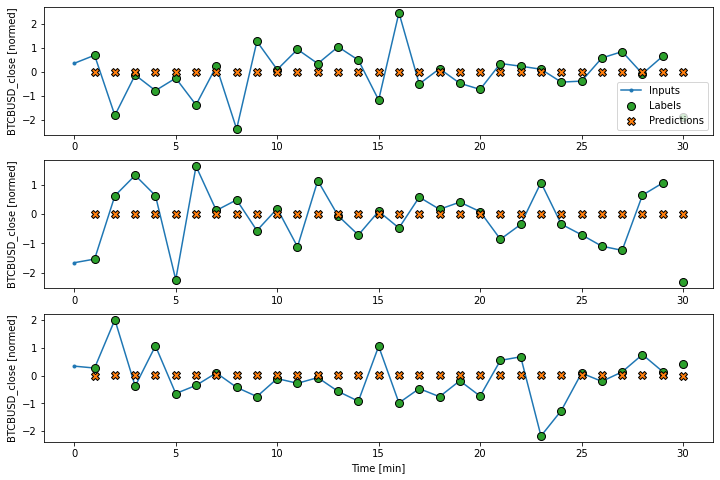

In [61]:
wide_window_d.plot(gru_bidi.model)

In [62]:
gru_bidi.save_model("g_bidi")

INFO:tensorflow:Assets written to: models_pct\models_21_09_2021_24_b_w_crypto_BTCBUSD_1\g_bidi.model\assets


INFO:tensorflow:Assets written to: models_pct\models_21_09_2021_24_b_w_crypto_BTCBUSD_1\g_bidi.model\assets


### Performance

In [63]:
"""
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]


plt.ylabel('mean_absolute_error [BTC-USD, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()
"""

"\nx = np.arange(len(performance))\nwidth = 0.3\nmetric_name = 'mean_absolute_error'\nmetric_index = lstm_model.metrics_names.index('mean_absolute_error')\nval_mae = [v[metric_index] for v in val_performance.values()]\ntest_mae = [v[metric_index] for v in performance.values()]\n\n\nplt.ylabel('mean_absolute_error [BTC-USD, normalized]')\nplt.bar(x - 0.17, val_mae, width, label='Validation')\nplt.bar(x + 0.17, test_mae, width, label='Test')\nplt.xticks(ticks=x, labels=performance.keys(),\n           rotation=45)\n_ = plt.legend()\n"

In [64]:
"""
for name, value in performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')
"""

"\nfor name, value in performance.items():\n    print(f'{name:12s}: {value[1]:0.4f}')\n"

## Single shot models
The entire sequence prediction in a single step.

24 min to the future with 2 min to the future

In [65]:
OUT_STEPS = 1

wide_window_d_single = WindowGenerator(
    input_width=30, label_width=OUT_STEPS, shift=FUTURE_PERIOD_PREDICT,train_df = train_df_d,val_df = val_df_d, test_df = test_df_d,label_columns=[RATIO_TO_PREDICT+'_close'])


In [66]:
single_val_performance = {}
single_performance = {}

### LSTM single shot

In [67]:
lstm_model_single = tf.keras.Sequential([
    
    tf.keras.layers.LSTM(1024,  return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(1024,  return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(1024,  return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(1024, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.Dense(64, activation=act),
    tf.keras.layers.Dense(32, activation=act),
    tf.keras.layers.Dense(units=1)
    
])


In [68]:
lstm_single = MyModel(lstm_model_single)

In [69]:
history = lstm_single.compile_and_fit(wide_window_d_single)

Epoch 1/120
2007/2007 [==============================] - 78s 36ms/step - loss: 1.0326 - mean_absolute_error: 0.6845 - val_loss: 0.7385 - val_mean_absolute_error: 0.6414
Epoch 2/120
2007/2007 [==============================] - 71s 36ms/step - loss: 1.0258 - mean_absolute_error: 0.6823 - val_loss: 0.6413 - val_mean_absolute_error: 0.5788
Epoch 3/120
2007/2007 [==============================] - 71s 36ms/step - loss: 1.0235 - mean_absolute_error: 0.6806 - val_loss: 0.6383 - val_mean_absolute_error: 0.5794
Epoch 4/120
2007/2007 [==============================] - 71s 36ms/step - loss: 1.0280 - mean_absolute_error: 0.6822 - val_loss: 0.6885 - val_mean_absolute_error: 0.6062
Epoch 5/120
2007/2007 [==============================] - 71s 36ms/step - loss: 1.0268 - mean_absolute_error: 0.6818 - val_loss: 0.6541 - val_mean_absolute_error: 0.5905
Epoch 6/120
2007/2007 [==============================] - 71s 35ms/step - loss: 1.0237 - mean_absolute_error: 0.6806 - val_loss: 0.6410 - val_mean_absolute_

In [70]:
single_val_performance['LSTM_single'] = lstm_single.eval_mod(wide_window_d_single.val, verbose=1)
single_performance['LSTM_single'] = lstm_single.eval_mod(wide_window_d_single.test, verbose=1)

1003/1003 [==============================] - 13s 13ms/step - loss: 0.6383 - mean_absolute_error: 0.5794
Loss: 0.638330340385437 MAE: 0.5793849229812622
334/334 [==============================] - 4s 13ms/step - loss: 1.5470 - mean_absolute_error: 0.7054
Loss: 1.5469800233840942 MAE: 0.7053589820861816


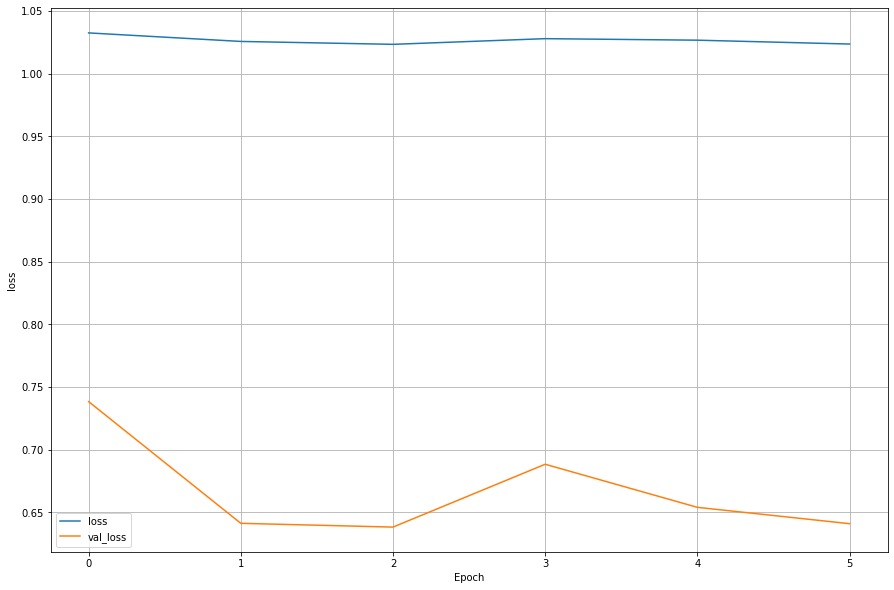

In [71]:
plot_loss(history, 'loss')

In [72]:
lstm_single.save_model("lstm_s")

INFO:tensorflow:Assets written to: models_pct\models_21_09_2021_24_b_w_crypto_BTCBUSD_1\lstm_s.model\assets


INFO:tensorflow:Assets written to: models_pct\models_21_09_2021_24_b_w_crypto_BTCBUSD_1\lstm_s.model\assets


### LSTM Bidirectional single shot

In [73]:
lstm_model_bidirectional_single = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1024, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1024, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1024, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1024, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Dense(64, activation=act),
    tf.keras.layers.Dense(32, activation=act),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [74]:
lstm_bidi_single = MyModel(lstm_model_bidirectional_single)

In [75]:
history = lstm_bidi_single.compile_and_fit(wide_window_d_single)

Epoch 1/120
2007/2007 [==============================] - 167s 77ms/step - loss: 1.0314 - mean_absolute_error: 0.6843 - val_loss: 0.6458 - val_mean_absolute_error: 0.5821
Epoch 2/120
2007/2007 [==============================] - 153s 76ms/step - loss: 1.0255 - mean_absolute_error: 0.6822 - val_loss: 0.6508 - val_mean_absolute_error: 0.5850
Epoch 3/120
2007/2007 [==============================] - 153s 76ms/step - loss: 1.0243 - mean_absolute_error: 0.6816 - val_loss: 0.6321 - val_mean_absolute_error: 0.5734
Epoch 4/120
2007/2007 [==============================] - 153s 76ms/step - loss: 1.0222 - mean_absolute_error: 0.6805 - val_loss: 0.6331 - val_mean_absolute_error: 0.5743
Epoch 5/120
2007/2007 [==============================] - 153s 76ms/step - loss: 1.0241 - mean_absolute_error: 0.6818 - val_loss: 0.6337 - val_mean_absolute_error: 0.5748
Epoch 6/120
2007/2007 [==============================] - 153s 76ms/step - loss: 1.0244 - mean_absolute_error: 0.6806 - val_loss: 0.6659 - val_mean_abs

In [76]:
single_val_performance['LSTM_bidi_single'] = lstm_bidi_single.eval_mod(wide_window_d_single.val, verbose=1)
single_performance['LSTM_bidi_single'] = lstm_bidi_single.eval_mod(wide_window_d_single.test, verbose=1)

1003/1003 [==============================] - 27s 27ms/step - loss: 0.6321 - mean_absolute_error: 0.5734
Loss: 0.6321459412574768 MAE: 0.5734018087387085
334/334 [==============================] - 9s 27ms/step - loss: 1.5360 - mean_absolute_error: 0.7000
Loss: 1.5359854698181152 MAE: 0.6999598145484924


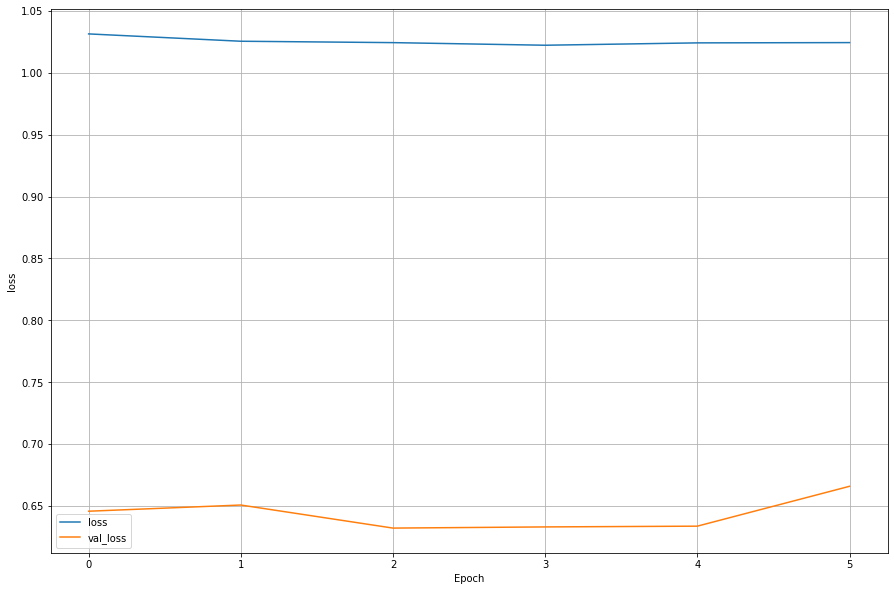

In [77]:
plot_loss(history, 'loss')

In [78]:
lstm_bidi_single.save_model("l_b_s")

INFO:tensorflow:Assets written to: models_pct\models_21_09_2021_24_b_w_crypto_BTCBUSD_1\l_b_s.model\assets


INFO:tensorflow:Assets written to: models_pct\models_21_09_2021_24_b_w_crypto_BTCBUSD_1\l_b_s.model\assets


### GRU single shot

In [79]:
gru_model_single = tf.keras.models.Sequential([

    tf.keras.layers.GRU(1024,  return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GRU(1024,  return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GRU(1024,  return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GRU(1024, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.Dense(64, activation=act),
    tf.keras.layers.Dense(32, activation=act),
    tf.keras.layers.Dense(units=1)
    
])


In [80]:
gru_single = MyModel(gru_model_single)

In [81]:
history = gru_single.compile_and_fit(wide_window_d_single)

Epoch 1/120
2007/2007 [==============================] - 66s 30ms/step - loss: 1.0298 - mean_absolute_error: 0.6834 - val_loss: 0.6328 - val_mean_absolute_error: 0.5756
Epoch 2/120
2007/2007 [==============================] - 60s 30ms/step - loss: 1.0215 - mean_absolute_error: 0.6791 - val_loss: 0.6322 - val_mean_absolute_error: 0.5751
Epoch 3/120
2007/2007 [==============================] - 60s 30ms/step - loss: 1.0221 - mean_absolute_error: 0.6804 - val_loss: 0.6408 - val_mean_absolute_error: 0.5782
Epoch 4/120
2007/2007 [==============================] - 61s 30ms/step - loss: 1.0209 - mean_absolute_error: 0.6786 - val_loss: 0.6308 - val_mean_absolute_error: 0.5737
Epoch 5/120
2007/2007 [==============================] - 61s 30ms/step - loss: 1.0212 - mean_absolute_error: 0.6797 - val_loss: 0.6674 - val_mean_absolute_error: 0.5943
Epoch 6/120
2007/2007 [==============================] - 61s 31ms/step - loss: 1.0225 - mean_absolute_error: 0.6806 - val_loss: 0.6433 - val_mean_absolute_

In [82]:
single_val_performance['GRU_single'] = gru_single.eval_mod(wide_window_d_single.val, verbose=1)
single_performance['GRU_single'] = gru_single.eval_mod(wide_window_d_single.test, verbose=1)

1003/1003 [==============================] - 9s 9ms/step - loss: 0.6308 - mean_absolute_error: 0.5737
Loss: 0.6308209896087646 MAE: 0.5736610889434814
334/334 [==============================] - 3s 9ms/step - loss: 1.5365 - mean_absolute_error: 0.7000
Loss: 1.5365158319473267 MAE: 0.7000246644020081


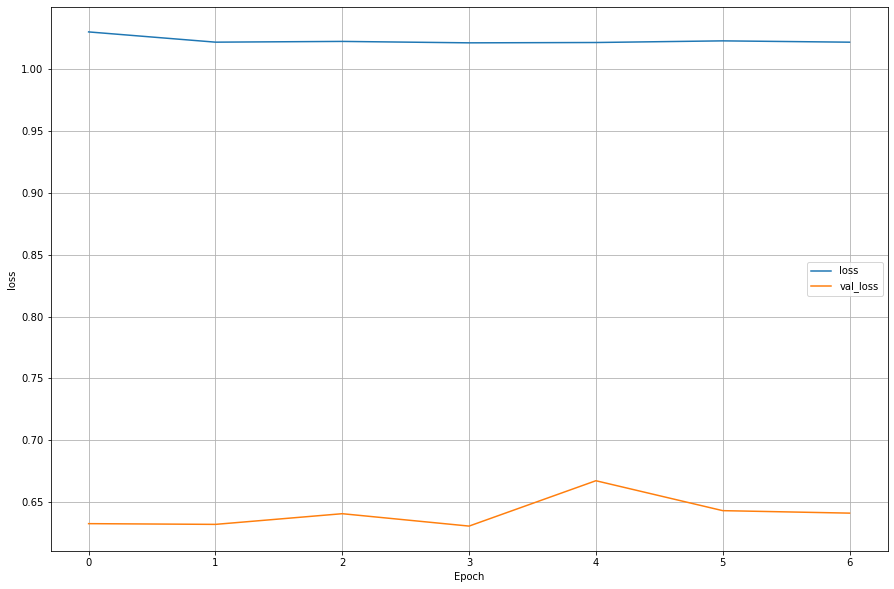

In [83]:
plot_loss(history, 'loss')

In [84]:
gru_single.save_model("gru_s")

INFO:tensorflow:Assets written to: models_pct\models_21_09_2021_24_b_w_crypto_BTCBUSD_1\gru_s.model\assets


INFO:tensorflow:Assets written to: models_pct\models_21_09_2021_24_b_w_crypto_BTCBUSD_1\gru_s.model\assets


### GRU Bidirectional single shot

In [85]:
gru_model_bidirectional_single = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(1024, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(1024, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(1024, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(1024, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Dense(64, activation=act),
    tf.keras.layers.Dense(32, activation=act),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [86]:
gru_bidi_single = MyModel(gru_model_bidirectional_single)

In [87]:
history = gru_bidi_single.compile_and_fit(wide_window_d_single)

Epoch 1/120
2007/2007 [==============================] - 140s 64ms/step - loss: 1.0331 - mean_absolute_error: 0.6843 - val_loss: 0.6315 - val_mean_absolute_error: 0.5744
Epoch 2/120
2007/2007 [==============================] - 127s 63ms/step - loss: 1.0204 - mean_absolute_error: 0.6795 - val_loss: 0.6390 - val_mean_absolute_error: 0.5772
Epoch 3/120
2007/2007 [==============================] - 127s 63ms/step - loss: 1.0255 - mean_absolute_error: 0.6818 - val_loss: 0.7756 - val_mean_absolute_error: 0.6580
Epoch 4/120
2007/2007 [==============================] - 127s 63ms/step - loss: 1.0218 - mean_absolute_error: 0.6801 - val_loss: 0.6305 - val_mean_absolute_error: 0.5732
Epoch 5/120
2007/2007 [==============================] - 127s 63ms/step - loss: 1.0238 - mean_absolute_error: 0.6814 - val_loss: 0.6708 - val_mean_absolute_error: 0.6034
Epoch 6/120
2007/2007 [==============================] - 127s 63ms/step - loss: 1.0224 - mean_absolute_error: 0.6808 - val_loss: 0.6811 - val_mean_abs

In [88]:
single_val_performance['GRU_bidi_single'] = gru_bidi_single.eval_mod(wide_window_d_single.val, verbose=1)
single_performance['GRU_bidi_single'] = gru_bidi_single.eval_mod(wide_window_d_single.test, verbose=1)

1003/1003 [==============================] - 19s 19ms/step - loss: 0.6305 - mean_absolute_error: 0.5732
Loss: 0.6305302977561951 MAE: 0.5731728672981262
334/334 [==============================] - 7s 19ms/step - loss: 1.5358 - mean_absolute_error: 0.6996
Loss: 1.535814642906189 MAE: 0.6996367573738098


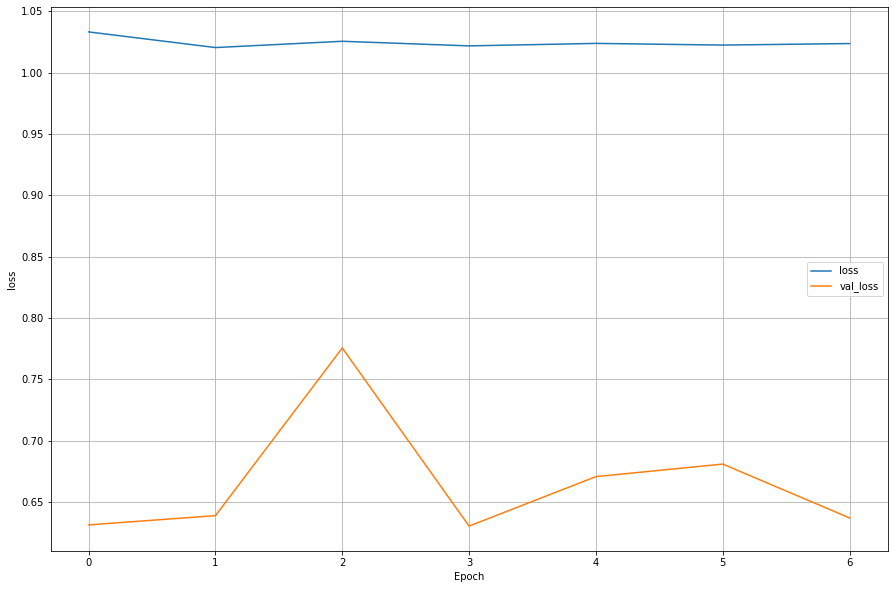

In [89]:
plot_loss(history, 'loss')

In [90]:
gru_bidi_single.save_model("g_b_s")

INFO:tensorflow:Assets written to: models_pct\models_21_09_2021_24_b_w_crypto_BTCBUSD_1\g_b_s.model\assets


INFO:tensorflow:Assets written to: models_pct\models_21_09_2021_24_b_w_crypto_BTCBUSD_1\g_b_s.model\assets


### Evaluating loaded models

In [91]:
import sys  
sys.path.insert(0, 'C:/Users/Admin/OneDrive - České vysoké učení technické v Praze/Plocha/Python/GraphPrediction')

import eval_models 


eval_class = eval_models.EvalClass("scalers/scaler_big_pct_24_b_w_BTC.gz" ,main_df, "models_21_09_2021_24_b_w_crypto_BTCBUSD_1", 30, "BTCBUSD")

C:\Users/Admin/OneDrive - České vysoké učení technické v Praze/Plocha/Python/GraphPrediction\eval_models.py:321: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x_axis_predictions,predictions, marker='x', edgecolors='k', label=model.name, c=c.reshape(1,-1), s=64)


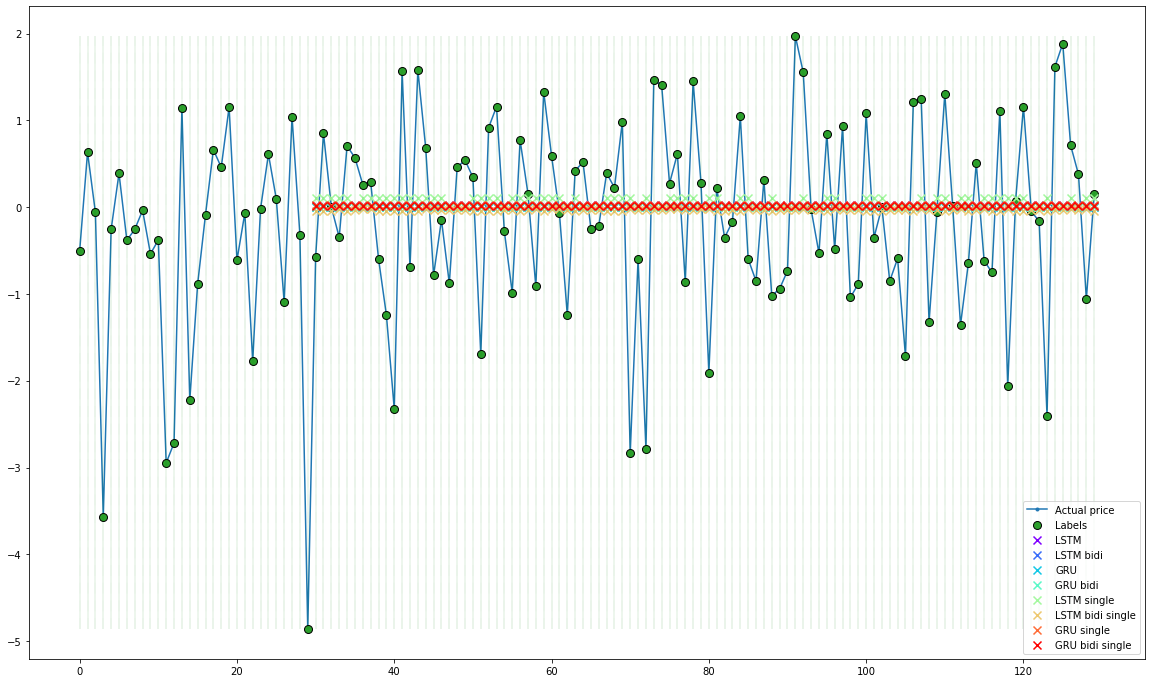

In [92]:
eval_class.plot_result(120, 100)

In [93]:
eval_class.get_ok_PCT(90000, 9000)

Correct
[4481, 4487, 4481, 4495, 4427, 4491, 4481, 4481]
Wrong
[4518, 4512, 4518, 4504, 4572, 4508, 4518, 4518]
Correct percentage
[49.79, 49.86, 49.79, 49.95, 49.19, 49.91, 49.79, 49.79]


In [94]:
eval_class.get_ok_PCT(100000, 7000)

Correct
[3470, 3515, 3470, 3522, 3449, 3521, 3470, 3470]
Wrong
[3529, 3484, 3529, 3477, 3550, 3478, 3529, 3529]
Correct percentage
[49.58, 50.22, 49.58, 50.32, 49.28, 50.31, 49.58, 49.58]


In [95]:
eval_class.trading_sim(100000, 100000,7000)

Final balance:
[96935.76862037955, 99870.99855573865, 96616.52324569385, 99929.89495724328, 77945.47817157036, 99994.66002947403, 96935.76862037955, 96935.76862037955]


C:\Users/Admin/OneDrive - České vysoké učení technické v Praze/Plocha/Python/GraphPrediction\eval_models.py:321: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x_axis_predictions,predictions, marker='x', edgecolors='k', label=model.name, c=c.reshape(1,-1), s=64)


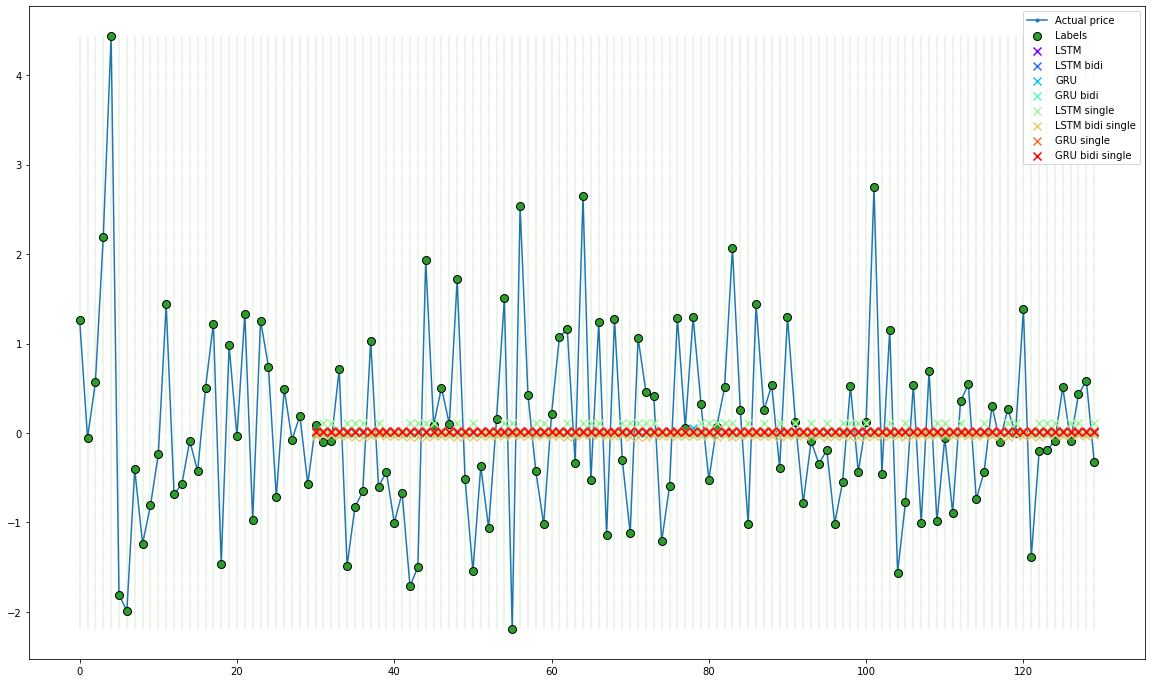

In [96]:
eval_class.plot_result(100000, 100)

In [97]:
eval_class.get_ok_PCT(120, 100)

Correct
[51, 48, 51, 48, 56, 48, 51, 51]
Wrong
[48, 51, 48, 51, 43, 51, 48, 48]
Correct percentage
[51.52, 48.48, 51.52, 48.48, 56.57, 48.48, 51.52, 51.52]
